In [1]:
import time
start = time.perf_counter()

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2026-02-19 13:17:45.284946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771525065.300379    4442 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771525065.305005    4442 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
print(tf.__version__)

2.18.0


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## LSTM 

### Single-step model 

In [10]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [11]:
# Values obtained from chapter 14

mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

In [12]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

I0000 00:00:1771525066.994533    4442 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9700 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Epoch 1/50


I0000 00:00:1771525069.814951    4473 cuda_dnn.cc:529] Loaded cuDNN version 90300


384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0401 - mean_absolute_error: 0.1407 - val_loss: 0.0156 - val_mean_absolute_error: 0.0906
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0108 - mean_absolute_error: 0.0746 - val_loss: 0.0079 - val_mean_absolute_error: 0.0631
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0066 - mean_absolute_error: 0.0579 - val_loss: 0.0054 - val_mean_absolute_error: 0.0535
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0053 - mean_absolute_error: 0.0516 - val_loss: 0.0044 - val_mean_absolute_error: 0.0484
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0047 - mean_absolute_error: 0.0489 - val_loss: 0.0041 - val_mean_absolute_error: 0.0460
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0465 - val_loss: 0.0036 - val_mean_absolute_error: 0.0431
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0039 - mean_absolute_error: 0.0442 - val_loss: 0.

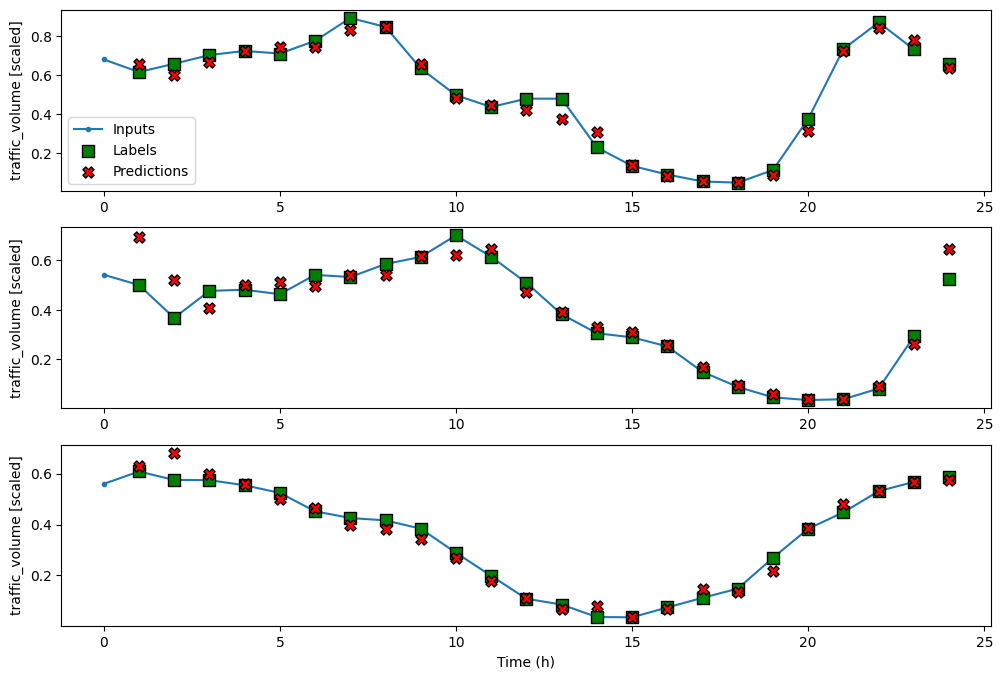

In [13]:
wide_window.plot(lstm_model)

plt.savefig('figures/CH15_F09_peixeiro.png', dpi=300)

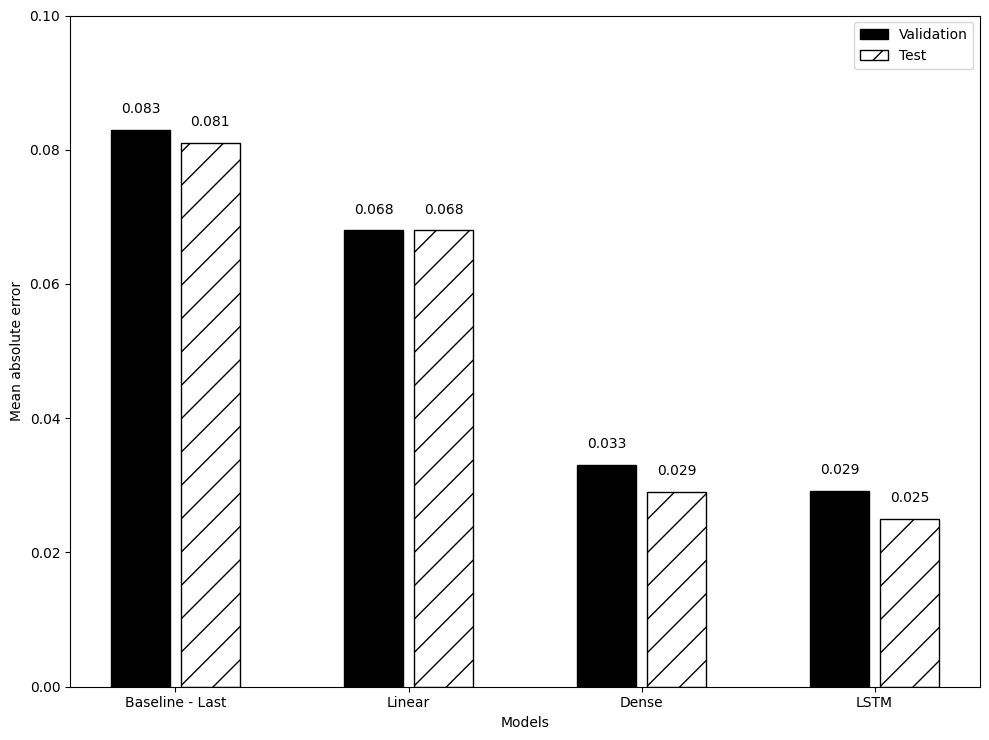

In [14]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH15_F10_peixeiro.png', dpi=300)

### Multi-step model 

In [15]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [16]:
# Values obtained from chapter 14

ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]

In [17]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0474 - mean_absolute_error: 0.1567 - val_loss: 0.0213 - val_mean_absolute_error: 0.1029
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0168 - mean_absolute_error: 0.0899 - val_loss: 0.0183 - val_mean_absolute_error: 0.0943
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0151 - mean_absolute_error: 0.0828 - val_loss: 0.0167 - val_mean_absolute_error: 0.0866
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0145 - mean_absolute_error: 0.0801 - val_loss: 0.0162 - val_mean_absolute_error: 0.0835
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0140 - mean_absolute_error: 0.0786 - val_loss: 0.0158 - val_mean_absolute_error: 0.0827
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0137 - mean_absolute_error: 0.0772 - val_loss: 0.0157 - val_mean_absolute_error: 0.0837
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0135 - mean_absolute_error: 0.0766 - v

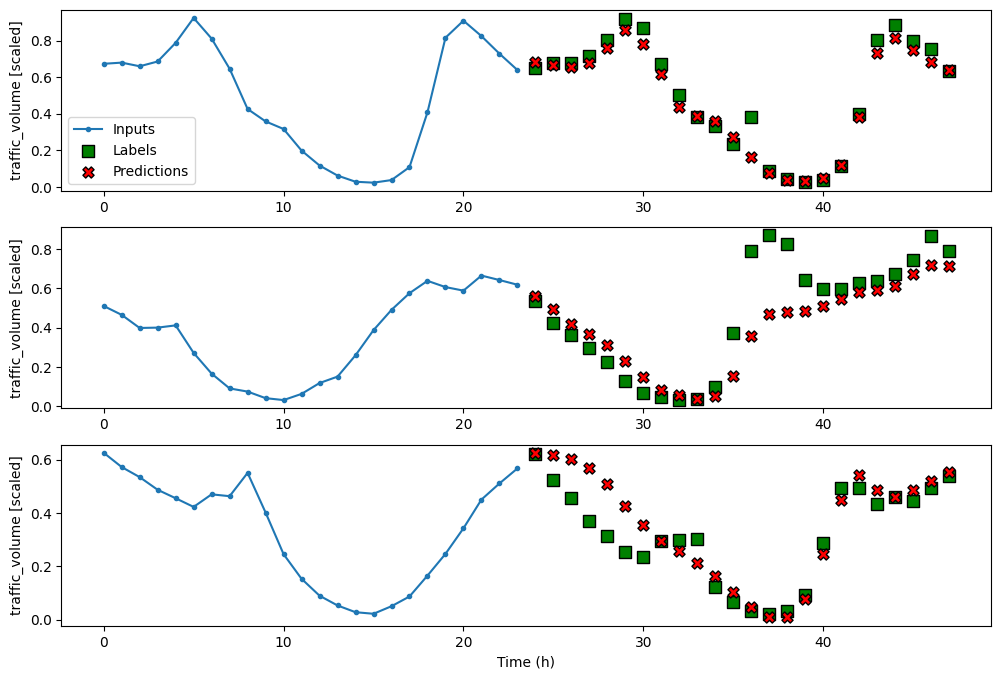

In [18]:
multi_window.plot(ms_lstm_model)

plt.savefig('figures/CH15_F11_peixeiro.png', dpi=300)

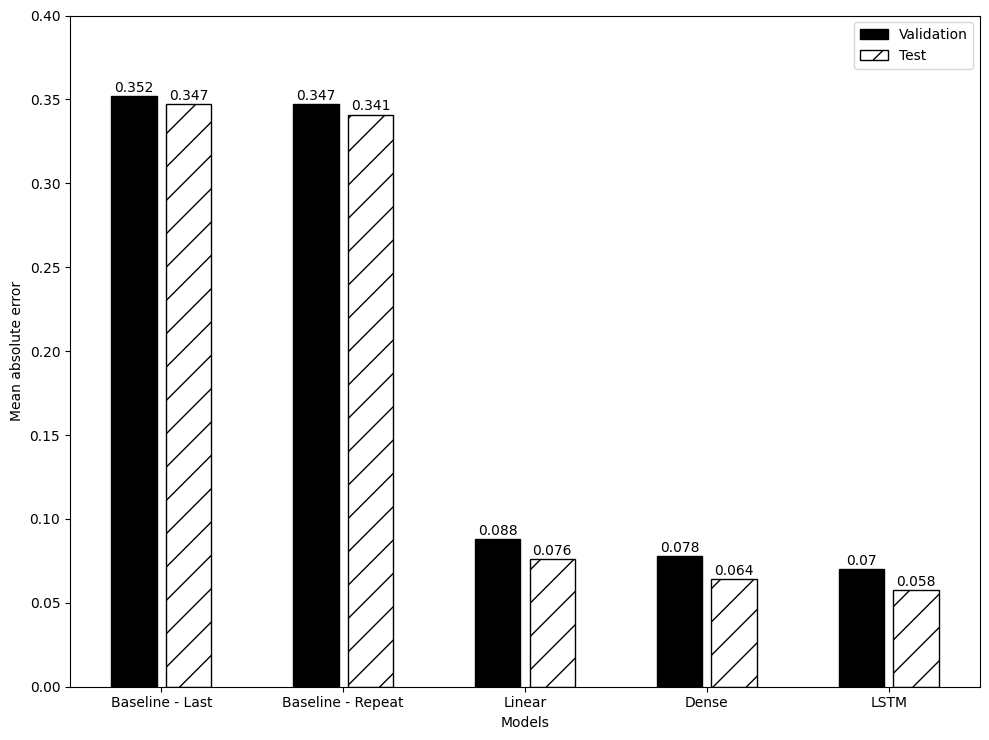

In [19]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH15_F12_peixeiro.png', dpi=300)

### Multi-output model 

In [20]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [21]:
# Values from chapter 14

mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

In [22]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0253 - mean_absolute_error: 0.1051 - val_loss: 0.0089 - val_mean_absolute_error: 0.0614
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0058 - mean_absolute_error: 0.0493 - val_loss: 0.0039 - val_mean_absolute_error: 0.0403
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0367 - val_loss: 0.0026 - val_mean_absolute_error: 0.0331
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0323 - val_loss: 0.0023 - val_mean_absolute_error: 0.0318
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0024 - mean_absolute_error: 0.0301 - val_loss: 0.0019 - val_mean_absolute_error: 0.0281
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0286 - val_loss: 0.0018 - val_mean_absolute_error: 0.0268
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0021 - mean_absolute_error: 0.0276 - v

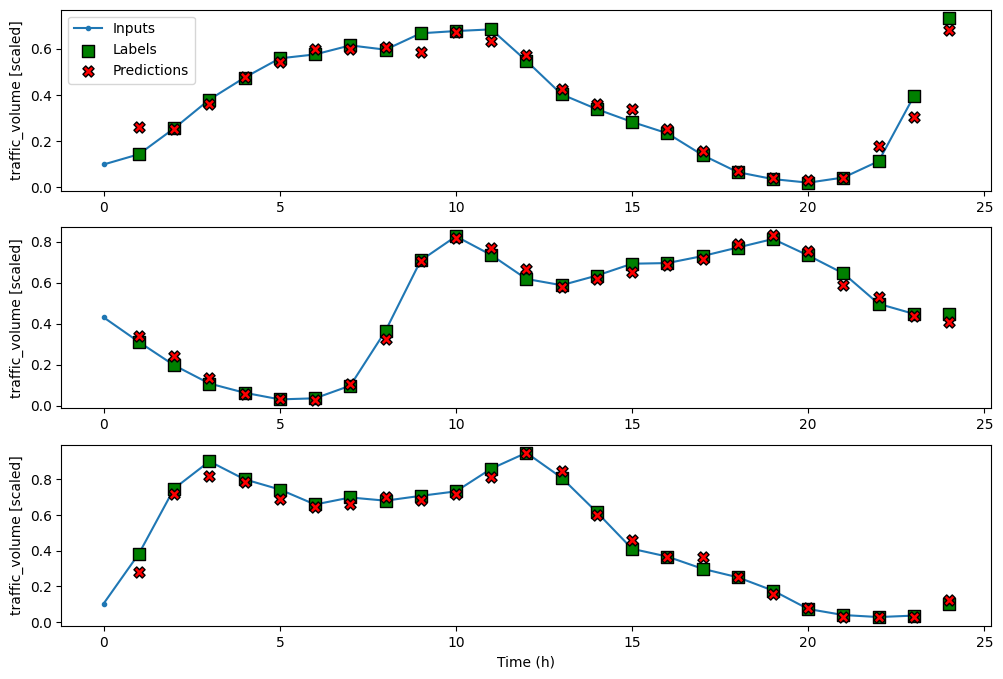

In [23]:
mo_wide_window.plot(mo_lstm_model)

plt.savefig('figures/CH15_F13_peixeiro.png', dpi=300)

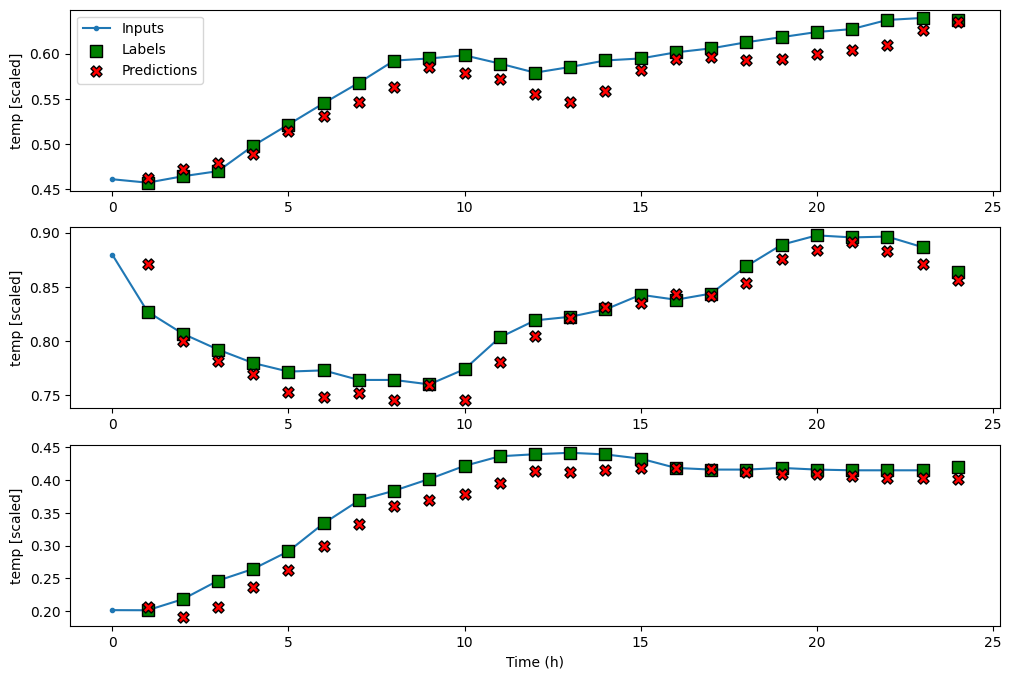

In [24]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

plt.savefig('figures/CH15_F14_peixeiro.png', dpi=300)

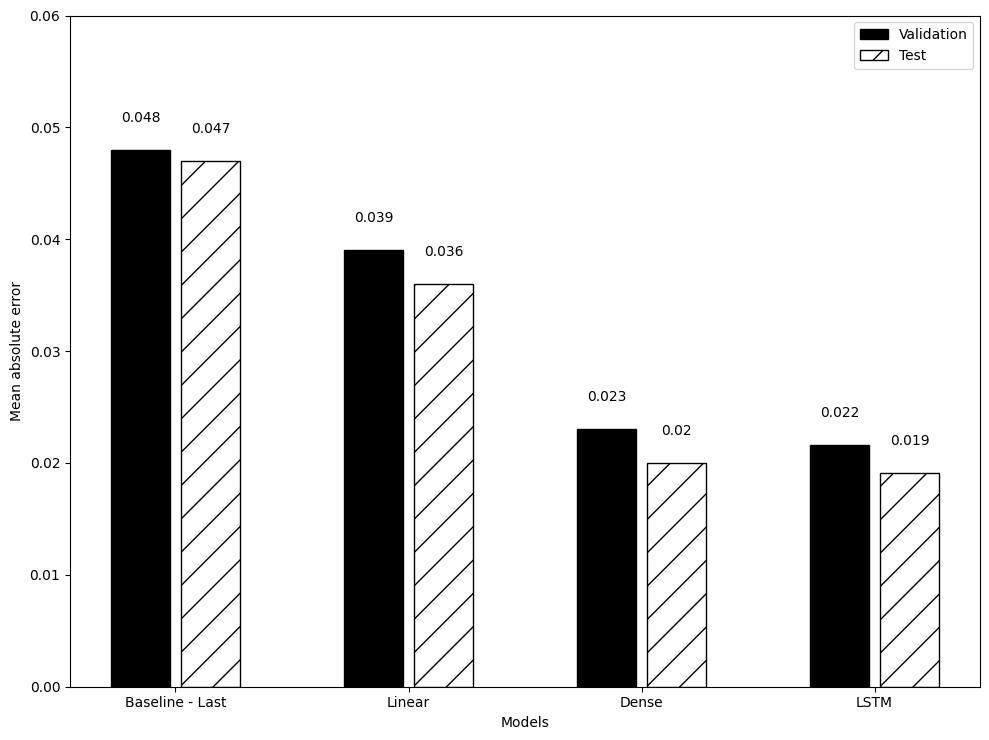

In [25]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH15_F15_peixeiro.png', dpi=300)

In [26]:
end = time.perf_counter()

elapsed_time = end - start
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 225.6673 seconds


3.12 LSTM Elapsed time: 225.6673 seconds